In [ ]:
#https://drive.google.com/file/d/10Mg323qVOYFUyMRlHVzl4sq_Grp5oxN3/view?usp=sharing



# FaceNet in a Nutshell

FaceNet suggests one of 6 Neural Network architectures - This is NN4 Small - an Inception model with 96x96 images as input  

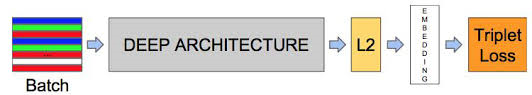

The input is 96x96x3 and the output is a 128d vector 

**Note: the last layer normalizes the embedding to be on the d-dim hyper sphere, with a distance of 1 from the 0-vector)**

In [1]:
from model import create_model
nn4_small2 = create_model()

In [2]:
nn4_small2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 48, 48, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn1 (BatchNormalization)       (None, 48, 48, 64)   256         ['conv1[0][0]']                  
                                                                                              

Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

$[z]_+$ means $max(z,0)$ and $m$ is the number of triplets in the training set. The triplet loss in Keras is best implemented with a custom layer as the loss function doesn't follow the usual `loss(input, target)` pattern. This layer calls `self.add_loss` to install the triplet loss:

In [3]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [4]:
nn4_small2_train.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          3743280     ['input_2[0][0]',                
                                                                  'input_3[0][0]',          

In [5]:
from data import triplet_generator

generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
100/100 [==============================] - 83s 709ms/step - loss: 0.8156
Epoch 2/10
100/100 [==============================] - 67s 671ms/step - loss: 0.8003
Epoch 3/10
100/100 [==============================] - 65s 653ms/step - loss: 0.8030
Epoch 4/10
100/100 [==============================] - 64s 645ms/step - loss: 0.8004
Epoch 5/10
100/100 [==============================] - 69s 695ms/step - loss: 0.7998
Epoch 6/10
100/100 [==============================] - 68s 681ms/step - loss: 0.7995
Epoch 7/10
100/100 [==============================] - 64s 644ms/step - loss: 0.8006
Epoch 8/10
100/100 [==============================] - 65s 652ms/step - loss: 0.8016
Epoch 9/10
100/100 [==============================] - 64s 644ms/step - loss: 0.8001
Epoch 10/10
100/100 [==============================] - 64s 642ms/step - loss: 0.8002


# Using a pre-trained OpenFace model on a custom dataset

Implementation of FaceNet trained on the public datasets FaceScrub and CASIA-WebFace

## Load the pre-trained model

In [21]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

## Prep the dataset

In [33]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [34]:
metadata = load_metadata('test_images')

In [35]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_68_face_landmarks.dat.bz2"
!mv *landmarks.dat landmarks.dat

--2022-11-08 06:10:36--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M   197MB/s    in 0.3s    

2022-11-08 06:10:36 (197 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

mv: target 'landmarks.dat' is not a directory


In [36]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

# OpenCV loads images with color channels
# in BGR order. So we need to reverse them
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    # Load an image
    original = load_image(metadata[img_index].image_path())

    # Detect face and return bounding box
    bb = alignment.getLargestFaceBoundingBox(original)

    # Transform image using specified face landmark indices and crop image to 96x96
    aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    plt.subplot(133)
    plt.imshow(aligned)

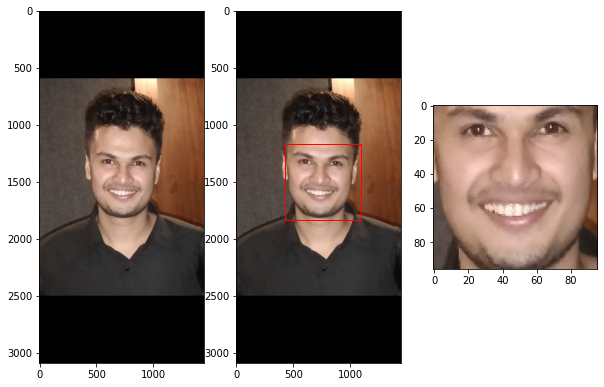

In [40]:
show_original_and_aligned(20)

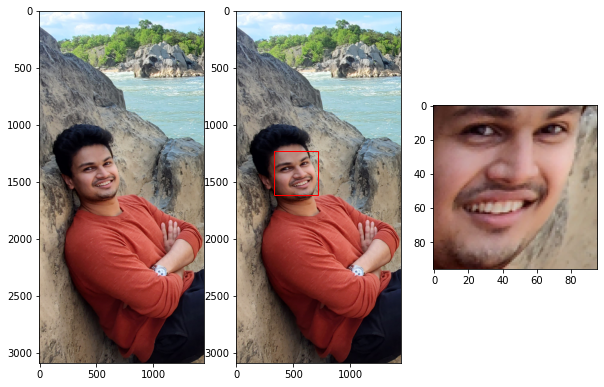

In [43]:
show_original_and_aligned(21)

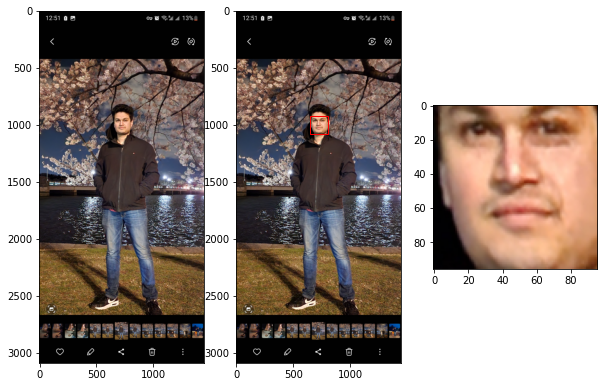

In [45]:
show_original_and_aligned(22)

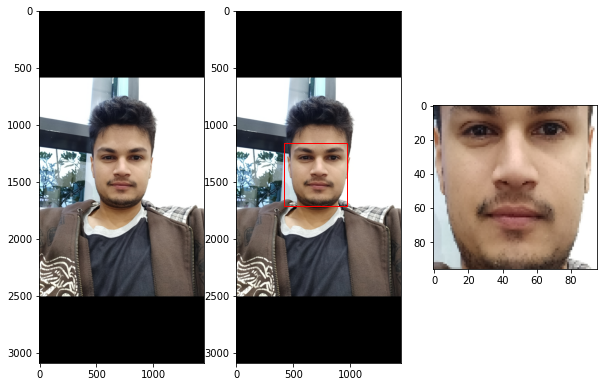

In [51]:
show_original_and_aligned(23)

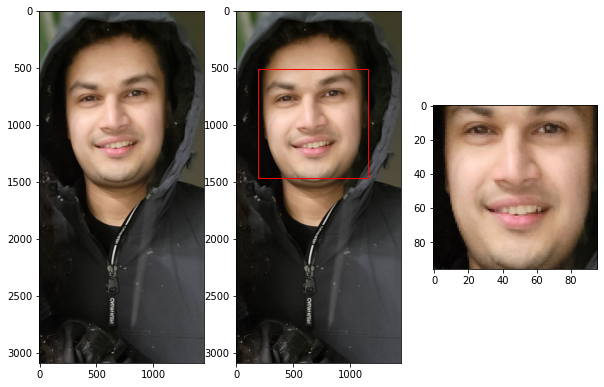

In [52]:
show_original_and_aligned(24)

In [41]:
#define for future use

def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Generate Embedding Vectors

In [42]:
from progressbar import ProgressBar

num_images = metadata.shape[0]
progress = ProgressBar(num_images)
progress.start()

embedded = np.zeros((num_images, 128))

for i, m in enumerate(metadata):
    #print(m.image_path())    
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
    progress.update(i)

/ |#                                                | 138 Elapsed Time: 0:00:00

1/1 [==============================] - 0s 45ms/step


- |  #                                                | 0 Elapsed Time: 0:00:00

1/1 [==============================] - 0s 45ms/step


\ |   #                                               | 1 Elapsed Time: 0:00:00

1/1 [==============================] - 0s 47ms/step


| |     #                                             | 2 Elapsed Time: 0:00:00

1/1 [==============================] - 0s 38ms/step


/ |      #                                            | 3 Elapsed Time: 0:00:00

1/1 [==============================] - 0s 42ms/step


- |        #                                          | 4 Elapsed Time: 0:00:00

1/1 [==============================] - 0s 44ms/step


\ |         #                                         | 5 Elapsed Time: 0:00:00

1/1 [==============================] - 0s 49ms/step


| |           #                                       | 6 Elapsed Time: 0:00:01

1/1 [==============================] - 0s 51ms/step


/ |             #                                     | 7 Elapsed Time: 0:00:01

1/1 [==============================] - 0s 48ms/step


- |               #                                   | 8 Elapsed Time: 0:00:01

1/1 [==============================] - 0s 42ms/step


\ |                #                                  | 9 Elapsed Time: 0:00:01

1/1 [==============================] - 0s 42ms/step


| |                  #                               | 10 Elapsed Time: 0:00:01

1/1 [==============================] - 0s 42ms/step


/ |                    #                             | 11 Elapsed Time: 0:00:02

1/1 [==============================] - 0s 37ms/step


- |                     #                            | 12 Elapsed Time: 0:00:02

1/1 [==============================] - 0s 45ms/step


\ |                       #                          | 13 Elapsed Time: 0:00:02

1/1 [==============================] - 0s 37ms/step


| |                        #                         | 14 Elapsed Time: 0:00:02

1/1 [==============================] - 0s 40ms/step


/ |                          #                       | 15 Elapsed Time: 0:00:02

1/1 [==============================] - 0s 36ms/step


- |                            #                     | 16 Elapsed Time: 0:00:02

1/1 [==============================] - 0s 40ms/step


\ |                             #                    | 17 Elapsed Time: 0:00:02

1/1 [==============================] - 0s 37ms/step


| |                               #                  | 18 Elapsed Time: 0:00:03

1/1 [==============================] - 0s 40ms/step


/ |                                 #                | 19 Elapsed Time: 0:00:03

1/1 [==============================] - 0s 38ms/step


- |                                #                 | 20 Elapsed Time: 0:00:06

1/1 [==============================] - 0s 38ms/step


\ |#                                                 | 21 Elapsed Time: 0:00:10

1/1 [==============================] - 0s 37ms/step


| |                                 #                | 22 Elapsed Time: 0:00:13

1/1 [==============================] - 0s 44ms/step


/ |                        #                         | 23 Elapsed Time: 0:00:17

1/1 [==============================] - 0s 38ms/step


- |        #                                         | 24 Elapsed Time: 0:00:20

1/1 [==============================] - 0s 46ms/step


\ |          #                                       | 25 Elapsed Time: 0:00:21

1/1 [==============================] - 0s 39ms/step


| |           #                                      | 26 Elapsed Time: 0:00:21

1/1 [==============================] - 0s 40ms/step


/ |             #                                    | 27 Elapsed Time: 0:00:21

1/1 [==============================] - 0s 40ms/step


- |              #                                   | 28 Elapsed Time: 0:00:21

1/1 [==============================] - 0s 37ms/step


\ |               #                                  | 29 Elapsed Time: 0:00:21

1/1 [==============================] - 0s 36ms/step


| |                 #                                | 30 Elapsed Time: 0:00:21

1/1 [==============================] - 0s 40ms/step


/ |                  #                               | 31 Elapsed Time: 0:00:21

1/1 [==============================] - 0s 37ms/step


- |                    #                             | 32 Elapsed Time: 0:00:22

1/1 [==============================] - 0s 42ms/step


\ |                      #                           | 33 Elapsed Time: 0:00:22

1/1 [==============================] - 0s 43ms/step


| |                       #                          | 34 Elapsed Time: 0:00:22

1/1 [==============================] - 0s 38ms/step


/ |                        #                         | 35 Elapsed Time: 0:00:22

1/1 [==============================] - 0s 37ms/step


- |                          #                       | 36 Elapsed Time: 0:00:22

1/1 [==============================] - 0s 38ms/step


\ |                           #                      | 37 Elapsed Time: 0:00:22

1/1 [==============================] - 0s 36ms/step


| |                            #                     | 38 Elapsed Time: 0:00:22

1/1 [==============================] - 0s 36ms/step


/ |                              #                   | 39 Elapsed Time: 0:00:23

1/1 [==============================] - 0s 45ms/step


- |                               #                  | 40 Elapsed Time: 0:00:23

1/1 [==============================] - 0s 49ms/step


\ |                                 #                | 41 Elapsed Time: 0:00:23

1/1 [==============================] - 0s 51ms/step


| |                                   #              | 42 Elapsed Time: 0:00:23

1/1 [==============================] - 0s 91ms/step


/ |                                     #            | 43 Elapsed Time: 0:00:23

1/1 [==============================] - 0s 111ms/step


- |                                        #         | 44 Elapsed Time: 0:00:24

1/1 [==============================] - 0s 67ms/step


\ |                                              #   | 45 Elapsed Time: 0:00:24

1/1 [==============================] - 0s 38ms/step


| |                                                 #| 46 Elapsed Time: 0:00:24

1/1 [==============================] - 0s 39ms/step


/ |                                                # | 47 Elapsed Time: 0:00:25

1/1 [==============================] - 0s 113ms/step


- |                                            #     | 48 Elapsed Time: 0:00:25

1/1 [==============================] - 0s 60ms/step


\ |                                          #       | 49 Elapsed Time: 0:00:25

1/1 [==============================] - 0s 114ms/step


| |                                     #            | 50 Elapsed Time: 0:00:26

1/1 [==============================] - 0s 89ms/step


/ |                                  #               | 51 Elapsed Time: 0:00:26

1/1 [==============================] - 0s 63ms/step


- |                               #                  | 52 Elapsed Time: 0:00:26

1/1 [==============================] - 0s 62ms/step


\ |                             #                    | 53 Elapsed Time: 0:00:27

1/1 [==============================] - 0s 58ms/step


| |                          #                       | 54 Elapsed Time: 0:00:27

1/1 [==============================] - 0s 89ms/step


/ |                        #                         | 55 Elapsed Time: 0:00:27

1/1 [==============================] - 0s 73ms/step


- |                     #                            | 56 Elapsed Time: 0:00:27

1/1 [==============================] - 0s 44ms/step


\ |                   #                              | 57 Elapsed Time: 0:00:28

1/1 [==============================] - 0s 45ms/step


| |                 #                                | 58 Elapsed Time: 0:00:28

1/1 [==============================] - 0s 39ms/step


/ |                #                                 | 59 Elapsed Time: 0:00:28

1/1 [==============================] - 0s 42ms/step


- |              #                                   | 60 Elapsed Time: 0:00:28

1/1 [==============================] - 0s 36ms/step


\ |             #                                    | 61 Elapsed Time: 0:00:28

1/1 [==============================] - 0s 41ms/step


| |           #                                      | 62 Elapsed Time: 0:00:28

1/1 [==============================] - 0s 42ms/step


/ |          #                                       | 63 Elapsed Time: 0:00:28

1/1 [==============================] - 0s 38ms/step


- |        #                                         | 64 Elapsed Time: 0:00:29

1/1 [==============================] - 0s 37ms/step


\ |       #                                          | 65 Elapsed Time: 0:00:29

1/1 [==============================] - 0s 37ms/step


| |      #                                           | 66 Elapsed Time: 0:00:29

1/1 [==============================] - 0s 38ms/step


/ |    #                                             | 67 Elapsed Time: 0:00:29

1/1 [==============================] - 0s 40ms/step


- |   #                                              | 68 Elapsed Time: 0:00:29

1/1 [==============================] - 0s 38ms/step


\ | #                                                | 69 Elapsed Time: 0:00:29

1/1 [==============================] - 0s 42ms/step


| |#                                                 | 70 Elapsed Time: 0:00:29

1/1 [==============================] - 0s 55ms/step


/ | #                                                | 71 Elapsed Time: 0:00:30

1/1 [==============================] - 0s 38ms/step


- |   #                                              | 72 Elapsed Time: 0:00:30

1/1 [==============================] - 0s 45ms/step


\ |    #                                             | 73 Elapsed Time: 0:00:30

1/1 [==============================] - 0s 38ms/step


| |     #                                            | 74 Elapsed Time: 0:00:30

1/1 [==============================] - 0s 38ms/step


/ |       #                                          | 75 Elapsed Time: 0:00:30

1/1 [==============================] - 0s 43ms/step


- |        #                                         | 76 Elapsed Time: 0:00:30

1/1 [==============================] - 0s 38ms/step


\ |          #                                       | 77 Elapsed Time: 0:00:31

1/1 [==============================] - 0s 38ms/step


| |           #                                      | 78 Elapsed Time: 0:00:31

1/1 [==============================] - 0s 35ms/step


/ |             #                                    | 79 Elapsed Time: 0:00:31

1/1 [==============================] - 0s 38ms/step


- |              #                                   | 80 Elapsed Time: 0:00:31

1/1 [==============================] - 0s 39ms/step


\ |               #                                  | 81 Elapsed Time: 0:00:31

1/1 [==============================] - 0s 37ms/step


| |                 #                                | 82 Elapsed Time: 0:00:31

1/1 [==============================] - 0s 35ms/step


/ |                   #                              | 83 Elapsed Time: 0:00:31

1/1 [==============================] - 0s 36ms/step


- |                    #                             | 84 Elapsed Time: 0:00:32

1/1 [==============================] - 0s 42ms/step


\ |                     #                            | 85 Elapsed Time: 0:00:32

1/1 [==============================] - 0s 40ms/step


| |                       #                          | 86 Elapsed Time: 0:00:32

1/1 [==============================] - 0s 37ms/step


/ |                        #                         | 87 Elapsed Time: 0:00:32

1/1 [==============================] - 0s 40ms/step


- |                          #                       | 88 Elapsed Time: 0:00:32

1/1 [==============================] - 0s 44ms/step


\ |                            #                     | 89 Elapsed Time: 0:00:32

1/1 [==============================] - 0s 43ms/step


| |                             #                    | 90 Elapsed Time: 0:00:32

1/1 [==============================] - 0s 113ms/step


/ |                                 #                | 91 Elapsed Time: 0:00:33

1/1 [==============================] - 0s 43ms/step


- |                                   #              | 92 Elapsed Time: 0:00:33

1/1 [==============================] - 0s 88ms/step


\ |                                     #            | 93 Elapsed Time: 0:00:33

1/1 [==============================] - 0s 97ms/step


| |                                        #         | 94 Elapsed Time: 0:00:34

1/1 [==============================] - 0s 96ms/step


/ |                                            #     | 95 Elapsed Time: 0:00:34

1/1 [==============================] - 0s 95ms/step


- |                                               #  | 96 Elapsed Time: 0:00:34

1/1 [==============================] - 0s 44ms/step


\ |                                                # | 97 Elapsed Time: 0:00:34

1/1 [==============================] - 0s 43ms/step


| |                                                 #| 98 Elapsed Time: 0:00:35

1/1 [==============================] - 0s 35ms/step


/ |                                                # | 99 Elapsed Time: 0:00:35

1/1 [==============================] - 0s 70ms/step


- |                                      #          | 100 Elapsed Time: 0:00:35

1/1 [==============================] - 0s 65ms/step


\ |                                   #             | 101 Elapsed Time: 0:00:35

1/1 [==============================] - 0s 87ms/step


| |                                 #               | 102 Elapsed Time: 0:00:35

1/1 [==============================] - 0s 59ms/step


/ |                             #                   | 103 Elapsed Time: 0:00:36

1/1 [==============================] - 0s 105ms/step


- |                          #                      | 104 Elapsed Time: 0:00:36

1/1 [==============================] - 0s 80ms/step


\ |                        #                        | 105 Elapsed Time: 0:00:36

1/1 [==============================] - 0s 80ms/step


| |                     #                           | 106 Elapsed Time: 0:00:37

1/1 [==============================] - 0s 217ms/step


/ |                #                                | 107 Elapsed Time: 0:00:37

1/1 [==============================] - 0s 81ms/step


- |           #                                     | 108 Elapsed Time: 0:00:38

1/1 [==============================] - 0s 35ms/step


\ |         #                                       | 109 Elapsed Time: 0:00:38

1/1 [==============================] - 0s 35ms/step


| |        #                                        | 110 Elapsed Time: 0:00:38

1/1 [==============================] - 0s 42ms/step


/ |      #                                          | 111 Elapsed Time: 0:00:38

1/1 [==============================] - 0s 43ms/step


- |     #                                           | 112 Elapsed Time: 0:00:38

1/1 [==============================] - 0s 43ms/step


\ |   #                                             | 113 Elapsed Time: 0:00:38

1/1 [==============================] - 0s 51ms/step


| | #                                               | 114 Elapsed Time: 0:00:39

1/1 [==============================] - 0s 40ms/step


/ |#                                                | 115 Elapsed Time: 0:00:39

1/1 [==============================] - 0s 38ms/step


- | #                                               | 116 Elapsed Time: 0:00:39

1/1 [==============================] - 0s 41ms/step


\ |   #                                             | 117 Elapsed Time: 0:00:39

1/1 [==============================] - 0s 38ms/step


| |    #                                            | 118 Elapsed Time: 0:00:39

1/1 [==============================] - 0s 39ms/step


/ |      #                                          | 119 Elapsed Time: 0:00:39

1/1 [==============================] - 0s 37ms/step


- |       #                                         | 120 Elapsed Time: 0:00:39

1/1 [==============================] - 0s 37ms/step


\ |         #                                       | 121 Elapsed Time: 0:00:40

1/1 [==============================] - 0s 37ms/step


| |          #                                      | 122 Elapsed Time: 0:00:40

1/1 [==============================] - 0s 40ms/step


/ |            #                                    | 123 Elapsed Time: 0:00:40

1/1 [==============================] - 0s 39ms/step


- |             #                                   | 124 Elapsed Time: 0:00:40

1/1 [==============================] - 0s 41ms/step


\ |              #                                  | 125 Elapsed Time: 0:00:40

1/1 [==============================] - 0s 42ms/step


| |                #                                | 126 Elapsed Time: 0:00:40

1/1 [==============================] - 0s 40ms/step


/ |                 #                               | 127 Elapsed Time: 0:00:40

1/1 [==============================] - 0s 43ms/step


- |                   #                             | 128 Elapsed Time: 0:00:41

1/1 [==============================] - 0s 46ms/step


\ |                    #                            | 129 Elapsed Time: 0:00:41

1/1 [==============================] - 0s 39ms/step


| |                      #                          | 130 Elapsed Time: 0:00:41

1/1 [==============================] - 0s 37ms/step


/ |                       #                         | 131 Elapsed Time: 0:00:41

1/1 [==============================] - 0s 35ms/step


- |                         #                       | 132 Elapsed Time: 0:00:41

1/1 [==============================] - 0s 39ms/step


\ |                          #                      | 133 Elapsed Time: 0:00:41

1/1 [==============================] - 0s 41ms/step


| |                            #                    | 134 Elapsed Time: 0:00:42

1/1 [==============================] - 0s 45ms/step


/ |                             #                   | 135 Elapsed Time: 0:00:42

1/1 [==============================] - 0s 42ms/step


- |                               #                 | 136 Elapsed Time: 0:00:42

1/1 [==============================] - 0s 49ms/step


\ |                                 #               | 137 Elapsed Time: 0:00:42

In [46]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

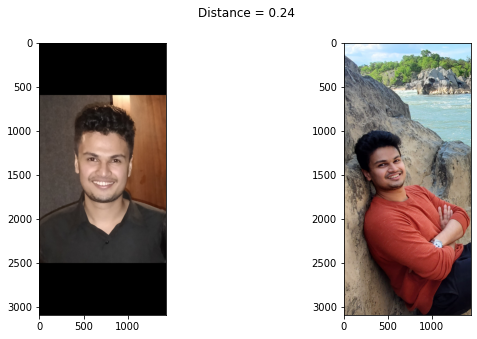

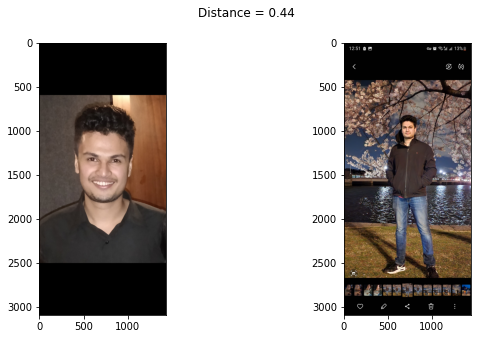

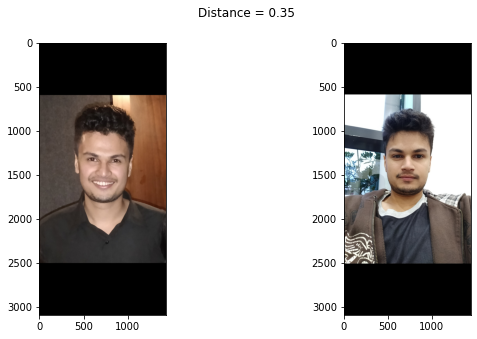

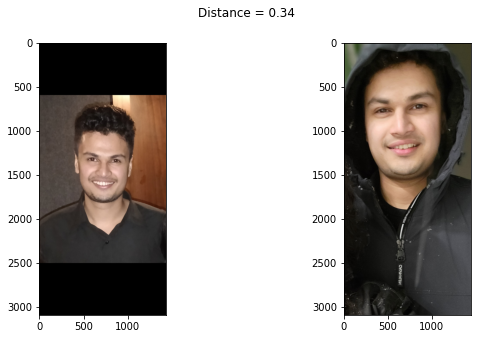

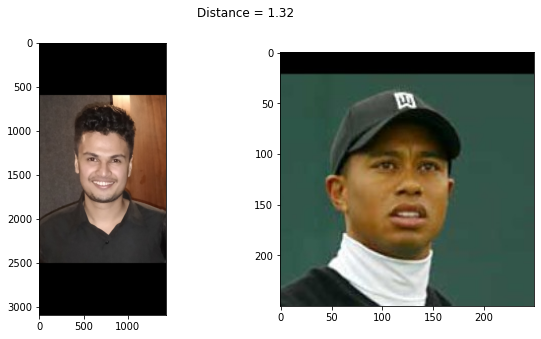

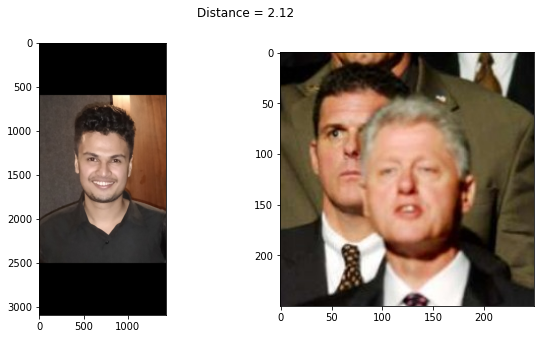

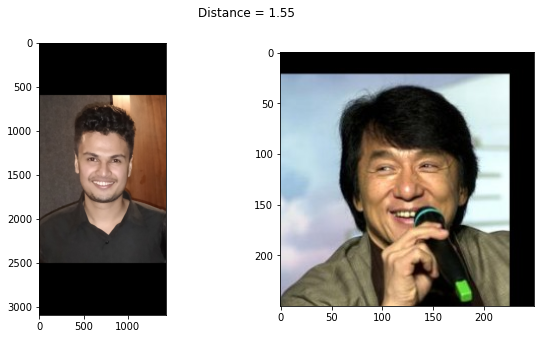

In [53]:
show_pair(20,21)
show_pair(20,22)
show_pair(20,23)
show_pair(20,24)
show_pair(20,25)
show_pair(20,65)
show_pair(20,113)

# What is the best threshold for the verification problem (Distance Treshold)

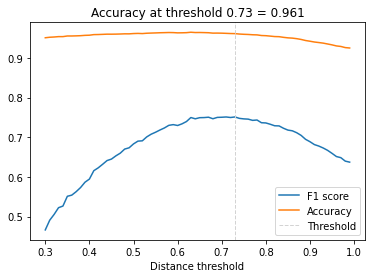

In [54]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

## Distance distributions of positive and negative pairs

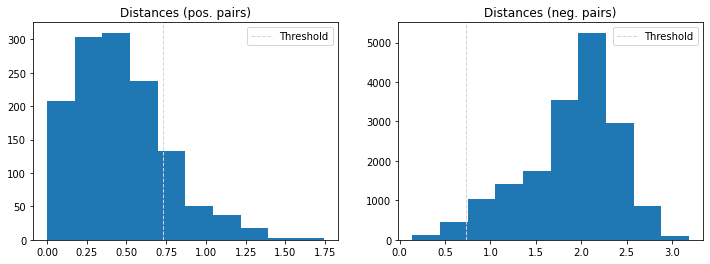

In [55]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

# Face recognition - with KNN or an SVM

50% used for training  
50% for validation

In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

test_idx = np.arange(metadata.shape[0]) % 2 != 0
train_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
y_pred_svc = knn.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.927536231884058, SVM accuracy = 0.927536231884058


In [57]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

def show_prediction(example_idx):
    plt.figure()
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction = knn.predict([embedded[test_idx][example_idx]])
    example_identity = encoder.inverse_transform(example_prediction)[0]

    plt.imshow(example_image)
    plt.title(f'Recognized as {example_identity}');
    
def show_predictions(indexes):
    plt.figure(figsize=(16,16))
    
    for i, idx in enumerate(indexes[:16]):
        example_image = load_image(metadata[test_idx][idx].image_path())
        example_prediction = knn.predict([embedded[test_idx][idx]])
        example_identity = encoder.inverse_transform(example_prediction)[0]

        plt.subplot(4,4,i+1)
        plt.imshow(example_image)
        plt.title(f'Recognized as {example_identity}');        

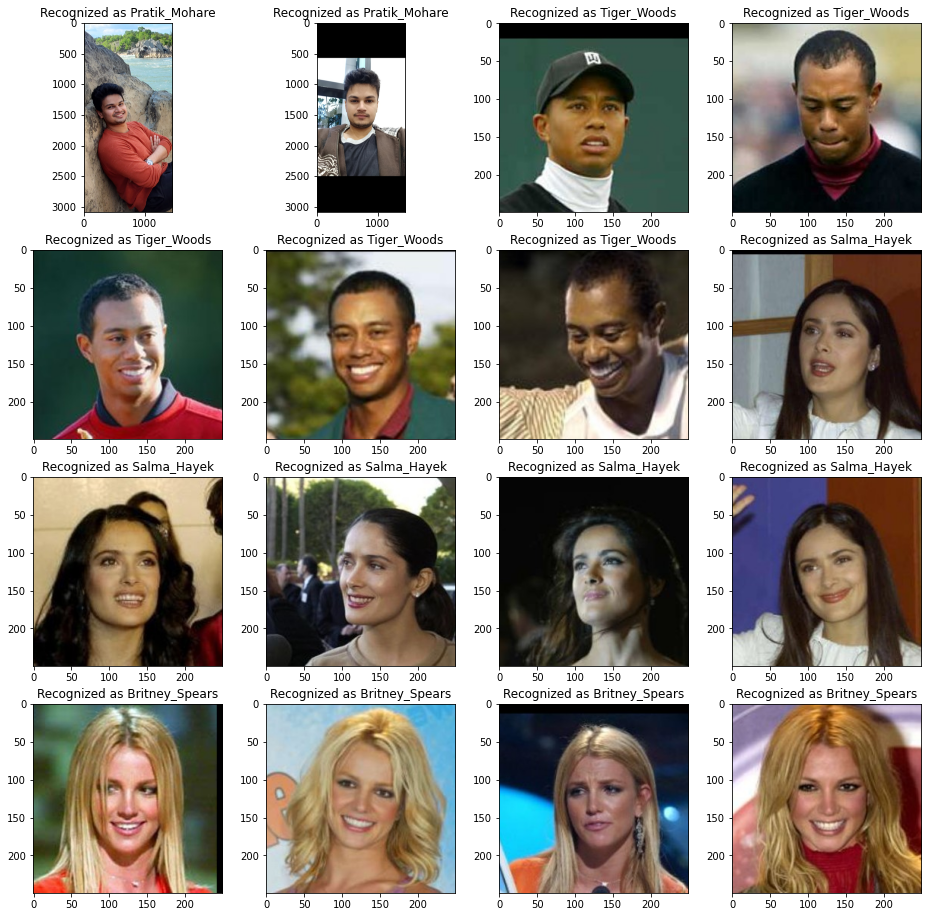

In [62]:
show_predictions(range(10,30))

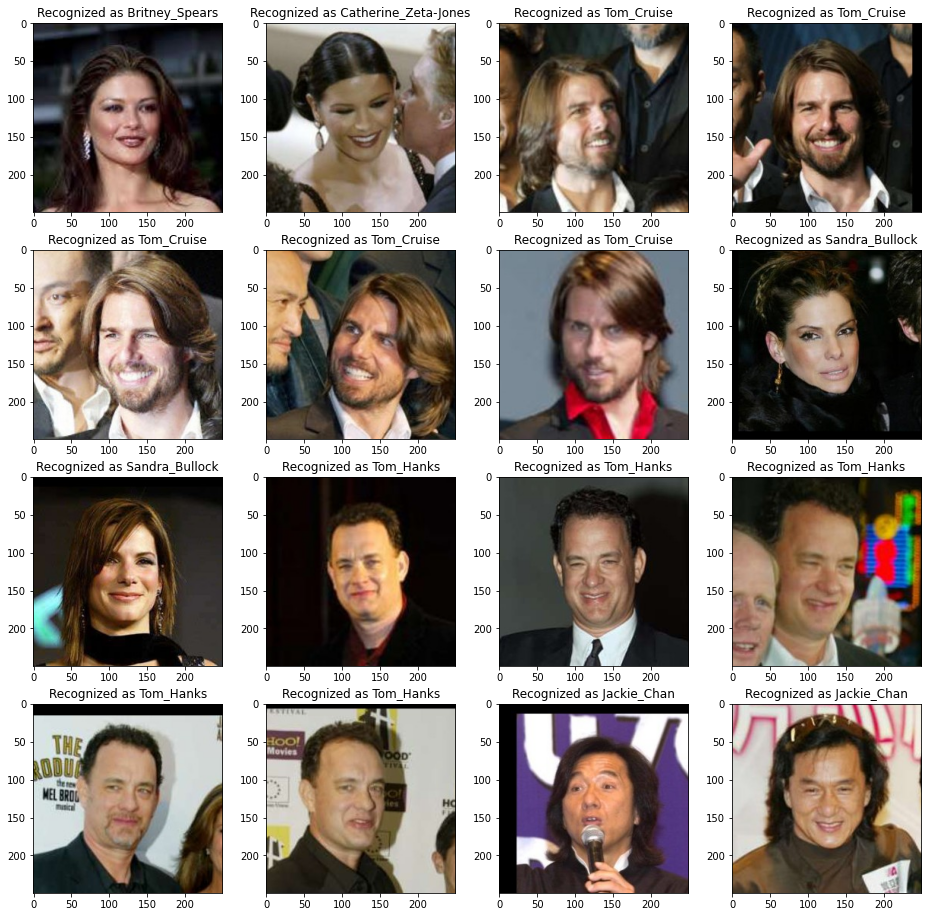

In [63]:
show_predictions(range(40,60))

## Missclassified images

[26, 27, 28, 40, 67]


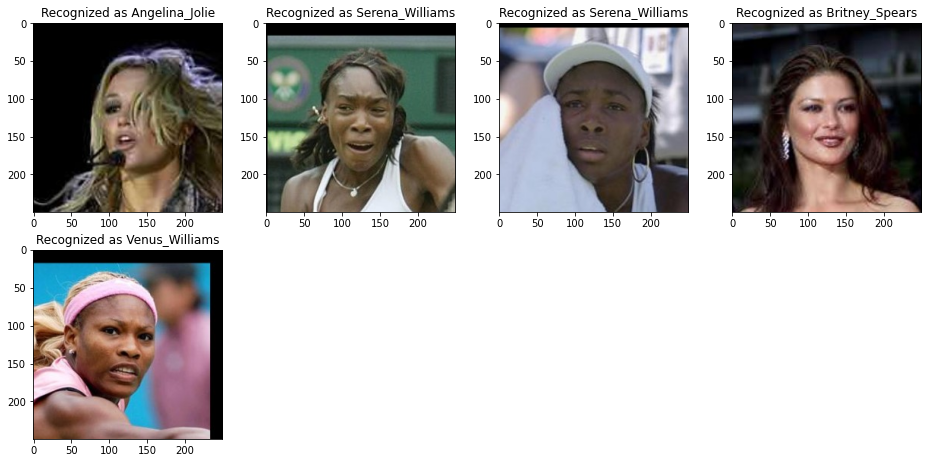

In [64]:
error_pairs = []

for i, item in enumerate(y_pred_knn):
    if item != y_test[i]:
        error_pairs.append(i)
        
print(error_pairs)

show_predictions(error_pairs)


# Dataset visualization

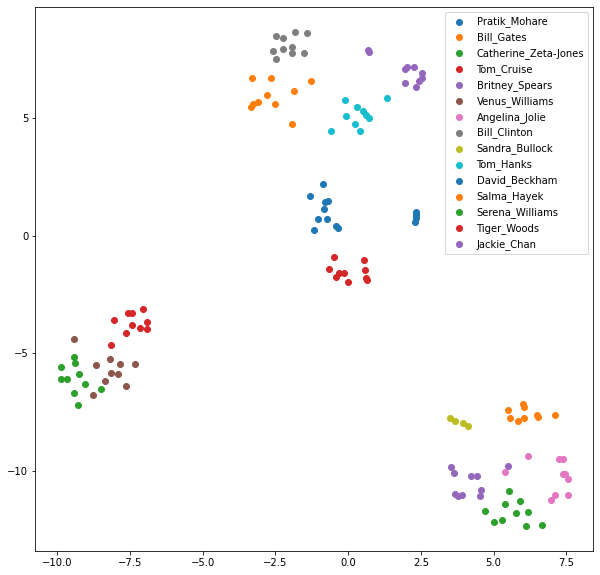

In [65]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

plt.figure(figsize=(10,10))

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));